# Configuración (importar dependencias, librerías, ...)

In [ ]:
!pip install --upgrade accelerate

In [ ]:
# Hiperparámetros
#model_checkpoint = 'xlm-roberta-base'
# model_checkpoint = 'bert-base-uncased'
# model_checkpoint = 'roberta-base'

# model_checkpoint = 'dccuchile/bert-base-spanish-wwm-uncased'
model_checkpoint = 'PlanTL-GOB-ES/roberta-base-bne'



In [ ]:
# Set the seed value all over the place to make this reproducible.
# esto hay que ponerlo justo antes de importar para que los experimentos
# sean reproducible

!pip install pytorch-lightning
import random
import torch
import numpy as np
import os
from pytorch_lightning import seed_everything

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)# Store the average loss after eachepoch so we can plot them.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["TF_DETERMINISTIC_OPS"] = "1" # See:https://github.com/NVIDIA/tensorflow-determinism#confirmed-current-gpu-specific-sources-of-non-determinism-with-solutions
seed_everything(42, workers=True)

!pip install transformers datasets
!pip install sentencepiece
!pip install contractions
!pip install textblob
!pip install optuna
from datasets import Dataset, DatasetDict, load_metric
import pandas as pd
import sklearn as sk
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, f1_score
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
 TrainingArguments, Trainer, pipeline, EarlyStoppingCallback

Seed set to 42


In [ ]:
import random
import torch
import numpy as np
import os
from pytorch_lightning import seed_everything

from datasets import Dataset, DatasetDict, load_metric
import pandas as pd
import sklearn as sk
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, f1_score
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
 TrainingArguments, Trainer, pipeline, EarlyStoppingCallback

In [ ]:
import torch

# Verificar si CUDA está disponible
if torch.cuda.is_available():
    # Obtener el nombre de la GPU
    gpu_name = torch.cuda.get_device_name(0)

    # Obtener la capacidad de la GPU
    gpu_capability = torch.cuda.get_device_capability(0)

    # Obtener la memoria total y disponible en la GPU
    gpu_memory_info = torch.cuda.get_device_properties(0)

    print(f"GPU Name: {gpu_name}")
    print(f"GPU Capability: {gpu_capability[0]}.{gpu_capability[1]}")
    print(f"Total GPU Memory: {gpu_memory_info.total_memory / (1024**3):.2f} GB")
    print(f"Free GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3) - torch.cuda.memory_allocated() / (1024**3):.2f} GB")
else:
    print("CUDA not available. Make sure your Jupyter Notebook is running with a GPU kernel.")

GPU Name: NVIDIA GeForce RTX 4070
GPU Capability: 8.9
Total GPU Memory: 11.72 GB
Free GPU Memory: 11.72 GB


In [ ]:
# Check that pyTorch is identifying the GPU
if torch.cuda.device_count() > 0:
  print(f'GPU detected. Currently using: "{torch.cuda.get_device_name(0)}"')
else:
  print('Currently using CPU, change the type of the runtime in the \'runtime\' tab')

GPU detected. Currently using: "NVIDIA GeForce RTX 4070"


# Preparación de los datos

## Lectura de los ficheros

In [ ]:
# Cargamos los datos de entrenamiento y test
import pandas as pd
data_path = '/home/manuelcerrejon/TFG/Task 1/Detests/BackTranslation/Datos/'
test_path = '/home/manuelcerrejon/TFG/Task 1/Detests/Preprocesing/Datos/'
# Los pasamos a dataframes
train_df = pd.read_csv(data_path + 'train_detests_df_a1_bt.csv', encoding = 'UTF-8', sep=',')
test_df = pd.read_csv(test_path + 'test_detests_df_a1_preprocesado.csv', encoding = 'UTF-8', sep=',')
valid_df = pd.read_csv(data_path + 'valid_detests_df_a1_bt.csv', encoding = 'UTF-8', sep=',')

nombre_etiqueta = 'label'
campo_texto = 'text'

In [ ]:
# Para saber el número de filas de cada clase en cada división
print("Distribución original - Train: ", train_df.value_counts(nombre_etiqueta))
print("Distribución original - Valid: ", valid_df.value_counts(nombre_etiqueta))
print("Distribución original - Test: ", test_df.value_counts(nombre_etiqueta))

Distribución original - Train:  label
0    2779
1    2112
dtype: int64
Distribución original - Valid:  label
0    797
1    601
dtype: int64
Distribución original - Test:  label
0    402
1    161
dtype: int64


## Reducción de los ficheros

In [ ]:
porcentaje = 0.2

In [ ]:
t1, t2 = train_test_split(train_df, test_size = porcentaje, stratify = train_df[nombre_etiqueta])
v1, v2 = train_test_split(valid_df, test_size = porcentaje, stratify = valid_df[nombre_etiqueta])

train_df_reduced = t1
valid_df_reduced = v1

In [ ]:
red_path = '/home/manuelcerrejon/TFG/Task 1/Detests/Hiperparametros/Datos/'

train_df_reduced.to_csv(red_path + "train_df_reducido_a1.csv", index=False)
valid_df_reduced.to_csv(red_path + "valid_df_reducido_a1.csv", index=False)

## Lectura de ficheros reducidos

In [ ]:
# data_path = './'
data_path = '/home/manuelcerrejon/TFG/Task 1/Detests/Hiperparametros/Datos/'
test_path = '/home/manuelcerrejon/TFG/Task 1/Detests/Preprocesing/Datos/'

train_df = pd.read_csv(data_path + 'train_df_reducido_a1.csv', encoding = 'UTF-8', sep=',')
test_df = pd.read_csv(test_path + 'test_detests_df_a1_preprocesado.csv', encoding = 'UTF-8', sep=',')
valid_df = pd.read_csv(data_path + 'valid_df_reducido_a1.csv', encoding = 'UTF-8', sep=',')

nombre_etiqueta = 'label'
campo_texto = 'text'

In [ ]:
# Para saber el número de filas de cada clase en cada división
print("Distribución original - Train: ", train_df.value_counts(nombre_etiqueta))
print("Distribución original - Valid: ", valid_df.value_counts(nombre_etiqueta))
print("Distribución original - Test: ", test_df.value_counts(nombre_etiqueta))

Distribución original - Train:  label
0    2223
1    1689
dtype: int64
Distribución original - Valid:  label
0    637
1    481
dtype: int64
Distribución original - Test:  label
0    402
1    161
dtype: int64


## Limpieza de datos

In [ ]:
# Esto solo es para ver la longitud (en palabras) de los tweets
def divide(texto):
  return texto.split()

def cuenta_tokens(lista):
  return len(lista)

train_df_palabras = train_df.copy()
train_df_palabras['text_split'] = train_df_palabras[campo_texto].apply(divide)
train_df_palabras['num_palabras'] = train_df_palabras['text_split'].apply(cuenta_tokens)
train_df_palabras

,id,text,label,text_split,num_palabras
0,d_118_02,"pero si, como dices vamos para atrás, el otro ...",0,"[pero, si,, como, dices, vamos, para, atrás,, ...",27
1,d_909_01,"en realidad no, es inmune, da igual el delito,...",0,"[en, realidad, no,, es, inmune,, da, igual, el...",38
2,d_1116_02,en fin hay gente muy valiente.,0,"[en, fin, hay, gente, muy, valiente.]",6
3,d_142_02,Solo ha que ver videos de barbaridades de lo q...,1,"[Solo, ha, que, ver, videos, de, barbaridades,...",29
4,d_824_01,"Es lógico, son 600.000 votos sobre la base de ...",1,"[Es, lógico,, son, 600.000, votos, sobre, la, ...",19
...,...,...,...,...,...
3907,d_1831_03,de estos temas no está ni se le espera,0,"[de, estos, temas, no, está, ni, se, le, espera]",9
3908,d_1002_01,"A ver yo no soy racista no , pero me gusta el ...",1,"[A, ver, yo, no, soy, racista, no, ,, pero, me...",20
3909,d_752_03,De esta manera aportarán dinero al Estado y a ...,1,"[De, esta, manera, aportarán, dinero, al, Esta...",20
3910,d_321_01,"se le ve equilibrado, eso por un zumo en alta ...",0,"[se, le, ve, equilibrado,, eso, por, un, zumo,...",23


In [ ]:
max = train_df_palabras.max()['num_palabras']
print(f'El texto de mayor longitud tiene {max} palabras')

El texto de mayor longitud tiene 181 palabras


In [ ]:
# Se convierten los dataframes en objetos datasets para que los acepten los transformers
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

print(train_dataset, valid_dataset, test_dataset)

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 3912
}) Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 1118
}) Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 563
})


In [ ]:
# Los objetos de tipo Dataset también se pueden mostrar en formato pandas
train_dataset.set_format("pandas")
train_dataset[:]

,id,text,label
0,d_118_02,"pero si, como dices vamos para atrás, el otro ...",0
1,d_909_01,"en realidad no, es inmune, da igual el delito,...",0
2,d_1116_02,en fin hay gente muy valiente.,0
3,d_142_02,Solo ha que ver videos de barbaridades de lo q...,1
4,d_824_01,"Es lógico, son 600.000 votos sobre la base de ...",1
...,...,...,...
3907,d_1831_03,de estos temas no está ni se le espera,0
3908,d_1002_01,"A ver yo no soy racista no , pero me gusta el ...",1
3909,d_752_03,De esta manera aportarán dinero al Estado y a ...,1
3910,d_321_01,"se le ve equilibrado, eso por un zumo en alta ...",0


In [ ]:
# Se pueden eliminar los dataframes puesto que no se van a usar más
del train_df
del valid_df
del test_df

# Preparación de los conjuntos para el entrenamiento

In [ ]:
# Se asigna una etiqueta numérica en función de la etiqueta principal

def set_labels(records):
  if records[nombre_etiqueta] == 0:
    label = 0
  else:
    label = 1
  return {'labels': label}

In [ ]:
# Reseteamos el formato para que no haya fallos
train_dataset.reset_format()
valid_dataset.reset_format()
test_dataset.reset_format()

In [ ]:
# Map the functions to the dataset
train_dataset = train_dataset.map(set_labels)
valid_dataset = valid_dataset.map(set_labels)

print(train_dataset, valid_dataset)

Map:   0%|          | 0/3912 [00:00<?, ? examples/s]

Map:   0%|          | 0/1118 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'text', 'label', 'labels'],
    num_rows: 3912
}) Dataset({
    features: ['id', 'text', 'label', 'labels'],
    num_rows: 1118
})


In [ ]:
# Reseteamos el formato para que no haya fallos
train_dataset.reset_format()
valid_dataset.reset_format()
test_dataset.reset_format()

# Proceso de clasificación

## Tokenización

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

In [ ]:
# Tamaño del vocabulario del tokenizador
tokenizer.vocab_size

50262

In [ ]:
# Crear un contenedor para los conteos de tokens por tweet
conteos_token_train = []
conteos_token_valid = []
# Tokenizar todos los tweets y registrar el número de tokens
for tweet in tqdm(train_dataset):
    tokens = tokenizer.tokenize(tweet[campo_texto])
    conteos_token_train.append(len(tokens))
for tweet in tqdm(valid_dataset):
    tokens = tokenizer.tokenize(tweet[campo_texto])
    conteos_token_valid.append(len(tokens))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:00<00:00, 12270.30it/s]


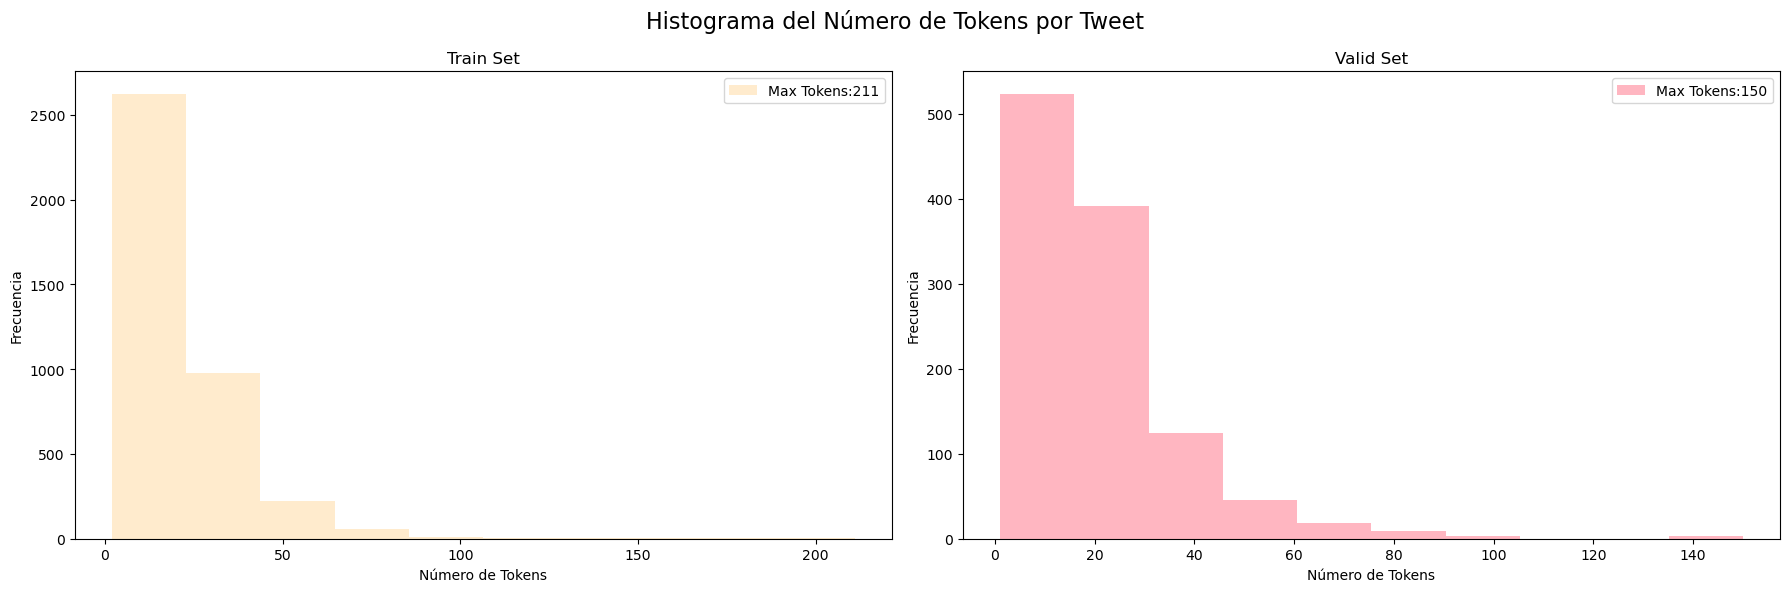

In [ ]:
del max

# Crear subgráficos
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
fig.suptitle('Histograma del Número de Tokens por Tweet', fontsize = 16)

# Subgráfico para el conjunto train
max_tokens_train = max(conteos_token_train)
axes[0].hist(conteos_token_train, color='blanchedalmond')
axes[0].set_title('Train Set')
axes[0].set_xlabel('Número de Tokens')
axes[0].set_ylabel('Frecuencia')
axes[0].legend(['Max Tokens:' + str(max_tokens_train)])

# Subgráfico para el conjunto valid
max_tokens_valid = max(conteos_token_valid)
axes[1].hist(conteos_token_valid, color='lightpink')
axes[1].set_title('Valid Set')
axes[1].set_xlabel('Número de Tokens')
axes[1].set_ylabel('Frecuencia')
axes[1].legend(['Max Tokens:' + str(max_tokens_valid)])

# Ajustar el diseño y mostrar los subgráficos
plt.tight_layout()
plt.show()

#### *Definir Longitud Máxima*

In [ ]:
# Definir MAX_LENGTH
MAX_LENGTH = 128

In [ ]:
# Función para tokenizar un dataset
def tokenize_data(examples):
  #return tokenizer(examples[campo_texto], truncation=True, padding='longest')
  return tokenizer(examples[campo_texto], truncation=True, max_length=MAX_LENGTH, padding=True)

In [ ]:
# Celda para para construir los ficheros codificados (encoded)
columns_train = train_dataset.column_names  # Coge todas las columnas
columns_valid = valid_dataset.column_names  # Coge todas las columnas
columns_train.remove("labels") # Elimina la columna "labels"
columns_valid.remove("labels") # Elimina la columna "labels"

# Hace el tokenizado y elimina todas las columnas que no se necesitan
encoded_train_dataset = train_dataset.map(tokenize_data, batched=True, remove_columns=columns_train)
encoded_valid_dataset = valid_dataset.map(tokenize_data, batched=True, remove_columns=columns_valid)
encoded_train_dataset

Map:   0%|          | 0/3912 [00:00<?, ? examples/s]

Map:   0%|          | 0/1118 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 3912
})

In [ ]:
len(encoded_train_dataset[3]['input_ids'])

In [ ]:
encoded_train_dataset[4]['input_ids']

In [ ]:
encoded_train_dataset[4]

## Carga del modelo

In [ ]:
# Se carga el modelo preentrenado
n_labels = 2
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint,
                                                              num_labels = n_labels)
                                                              # use_auth_token = 'token propio de HugginFace')

In [ ]:
# Para saber el nombre del modelo
model_name = model_checkpoint.split("/")[-1]
model_name

'roberta-base-bne'

## Definición de la métricas

In [ ]:
# Función para realizar distintas métricas en ejecución

def compute_metrics(eval_pred):

  ##############
  ## preds son logits, que son tuplas de la forma [valor1, valor2]
  ## Por ejemplo [-1.5606991,  1.6122842] significa que ha predicho eso para un documento
  ## Eso es lo que pasa a la última capa del transformer (softmax si es binario)
  ## Por eso se utiliza el índice del valor máximo de la tupla, para decir que esa es la clase que predice
  ##############

  labels = eval_pred.label_ids
  preds = eval_pred.predictions.argmax(-1)

  precision, recall, f1, _ = sk.metrics.precision_recall_fscore_support(labels, preds, average="macro")
  f1_minoritaria = f1_score(labels, preds, pos_label=1)
  f1_mayoritaria = f1_score(labels, preds, pos_label=0)
  acc = sk.metrics.accuracy_score(labels, preds)
  AUC = roc_auc_score(labels, preds)
  PREC_REC = average_precision_score(labels, preds)
  return { 'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall, 'AUC': AUC,
           'f1_minoritaria': f1_minoritaria, 'f1_mayoritaria': f1_mayoritaria, 'PREC_REC': PREC_REC }

In [ ]:
##### Otra forma de definir las métricas
'''
accuracy = load_metric('accuracy')
f1 = load_metric('f1')

def compute_metric(eval_pred, test=False):
  predictions, labels = eval_pred

  if test == False:
    predictions = np.argmax(predictions, axis=1)

  result_acc = accuracy.compute(predictions=predictions, references=labels)['accuracy']
  result_f1 = f1.compute(predictions=predictions, references=labels)['f1']

  return {'accuracy': result_acc, 'f1-score': result_f1}
  '''
##### Otra forma de definir las métricas

## Configuración de la búsqueda de hiperparámetros

#### *Definir el Número de Épocas*

In [ ]:
# Definir NUM_TRAIN_EPOCHS
NUM_TRAIN_EPOCHS = 10

In [ ]:
import optuna
from functools import partial

In [ ]:
def maximum(a, b):
    if a >= b:
        return a
    else:
        return b

#### *Estructura de Búsqueda*

In [ ]:
# Crear un espacio de búsqueda de hiperparámetros
search_space = {
    "per_device_train_batch_size": [16, 32],
    "learning_rate": [3e-5, 5e-5],
    "weight_decay": [0.01, 0.1],
}

In [ ]:
# Calcular Numero de busquedas
nbusquedas = 1
for options in search_space.values():
    nbusquedas *= len(options)

In [ ]:
# Función objetivo para Optuna
def compute_objective(trial):

    # Obtener los hiperparámetros sugeridos por Optuna
    # hparams = optuna_hp_space(trial)
    hparams = {key: trial.suggest_categorical(key, values) for key, values in search_space.items()}

    # Se definen los parámetros del Trainer()
    num_train_samples = int(len(encoded_train_dataset))
    num_evaluation= int(len(encoded_valid_dataset))

    value = len(encoded_train_dataset) // (2 * hparams["per_device_train_batch_size"] * NUM_TRAIN_EPOCHS)
    logging_steps = maximum(1, value)

    optim = ["adamw_hf", "adamw_torch", "adamw_apex_fused", "adafactor", "adamw_torch_xla"]

    training_args = TrainingArguments(
        output_dir='results',
        num_train_epochs=NUM_TRAIN_EPOCHS,
        learning_rate=hparams["learning_rate"],
        per_device_train_batch_size=hparams["per_device_train_batch_size"],
        per_device_eval_batch_size=hparams["per_device_train_batch_size"],
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        weight_decay=hparams["weight_decay"],
        evaluation_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=3,
        optim=optim[1],
        push_to_hub=False
    )

    # Configurar el objeto Trainer con los hiperparámetros dados
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        train_dataset=encoded_train_dataset,
        eval_dataset=encoded_valid_dataset,
        tokenizer=tokenizer,
    )

    # Entrenar el modelo y obtener la métrica de interés
    trainer.train()

    # Evaluar el modelo en el conjunto de validación
    result = trainer.evaluate()
    print(result)

    # Obtener la métrica de interés, en este caso, F1
    metric = result['eval_f1']

    # Devolver la métrica como resultado para la optimización de Optuna
    return metric

In [ ]:
best_number = 0
best_result = 0

# ruta_callback = './hp/'
ruta_callback = '/home/manuelcerrejon/TFG/Task 1/Detests/Hiperparametros/Resultados/'

# Callback para guardar los resultados en cada iteración
def callback(study, trial, busqueda, modelo):
    # Obtener la información relevante de la iteración actual
    trial_value = trial.value
    trial_params = trial.params

    global best_result, best_number

    # Actualizar el mejor resultado
    if trial_value > best_result:
        best_number = trial.number
        best_result = trial_value

    # Guardar los resultados en un archivo o en cualquier otra estructura de datos
    with open(ruta_callback + 'hiperparametros_' + busqueda +'_' + modelo +'.txt', 'a') as f:
        if trial.number == 0:
            f.write(f"Estudio de Hiperparámetros. Búsqueda: {busqueda}, Modelo: {modelo}\n\n")
        f.write(f"Iteración: {trial.number}, Valor: {trial_value}, HP: {trial_params}, Mejor: {best_number}\n")

## Estudio de hiperparámetros

In [ ]:
# # Búsqueda heurística
# metodo = 'heuristica'
# study = optuna.create_study(direction='maximize')

In [ ]:
# # Búsqueda aleatoria
# metodo = 'aleatoria'
# study = optuna.create_study(sampler=optuna.samplers.RandomSampler(), direction='maximize')

In [ ]:
# Búsqueda exhaustiva
metodo = 'exhaustiva'
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.GridSampler(search_space))

[I 2024-04-16 10:57:43,345] A new study created in memory with name: no-name-436749fb-3adb-45b8-b742-1ad7500e21a1


In [ ]:
# Obtener nombre del modelo acortado
model_short = model_name.split("-")[0]
# model_short = 'prueba'
model_short

'roberta'

In [ ]:
# Crear una versión de callback con argumentos fijos
partial_callback = partial(callback, busqueda=metodo, modelo=model_short)

In [ ]:
# Realizar la optimización de hiperparámetros
study.optimize(compute_objective, n_trials=nbusquedas, callbacks=[partial_callback])

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

loading configuration file config.json from cache at /home/manuelcerrejon/.cache/huggingface/hub/models--PlanTL-GOB-ES--roberta-base-bne/snapshots/0e598176534f3cf2e30105f8286cf2503d6e4731/config.json
Model config RobertaConfig {
  "_name_or_path": "PlanTL-GOB-ES/roberta-base-bne",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50262
}



pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /home/manuelcerrejon/.cache/huggingface/hub/models--PlanTL-GOB-ES--roberta-base-bne/snapshots/0e598176534f3cf2e30105f8286cf2503d6e4731/pytorch_model.bin
Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,F1 Minoritaria,F1 Mayoritaria,Prec Rec
1,No log,0.348976,0.862254,0.854881,0.877072,0.847299,0.847299,0.822171,0.887591,0.796182
2,No log,0.337424,0.866726,0.862720,0.867646,0.859625,0.859625,0.839266,0.886173,0.787664
3,No log,0.596160,0.846154,0.845616,0.847812,0.854555,0.854555,0.836502,0.854730,0.741567
4,No log,0.753563,0.854204,0.847222,0.864332,0.840744,0.840744,0.814562,0.879882,0.779498
5,0.161500,0.790926,0.863148,0.859948,0.861368,0.858776,0.858776,0.838778,0.881119,0.777920


***** Running Evaluation *****
  Num examples = 1118
  Batch size = 32
Saving model checkpoint to results/checkpoint-123
Configuration saved in results/checkpoint-123/config.json
Model weights saved in results/checkpoint-123/pytorch_model.bin
tokenizer config file saved in results/checkpoint-123/tokenizer_config.json
Special tokens file saved in results/checkpoint-123/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1118
  Batch size = 32
Saving model checkpoint to results/checkpoint-246
Configuration saved in results/checkpoint-246/config.json
Model weights saved in results/checkpoint-246/pytorch_model.bin
tokenizer config file saved in results/checkpoint-246/tokenizer_config.json
Special tokens file saved in results/checkpoint-246/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-369] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1118
  Batch size = 32
Saving model checkpoint to results/checkpoint-369
Configura

[I 2024-04-16 11:00:13,539] Trial 0 finished with value: 0.8627195508977348 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.8627195508977348.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /home/manuelcerrejon/.cache/huggingface/hub/models--PlanTL-GOB-ES--roberta-base-bne/snapshots/0e598176534f3cf2e30105f8286cf2503d6e4731/config.json
Model config RobertaConfig {
  "_name_or_path": "PlanTL-GOB-ES/roberta-base-bne",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  

{'eval_loss': 0.33742401003837585, 'eval_accuracy': 0.8667262969588551, 'eval_f1': 0.8627195508977348, 'eval_precision': 0.8676462737561392, 'eval_recall': 0.8596249310535025, 'eval_AUC': 0.8596249310535025, 'eval_f1_minoritaria': 0.8392664509169363, 'eval_f1_mayoritaria': 0.8861726508785333, 'eval_PREC_REC': 0.7876635108358958, 'eval_runtime': 1.9916, 'eval_samples_per_second': 561.344, 'eval_steps_per_second': 17.573, 'epoch': 5.0}


Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.out_proj.weight', 'classi

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,F1 Minoritaria,F1 Mayoritaria,Prec Rec
1,No log,0.352445,0.846154,0.845195,0.845016,0.851754,0.851754,0.833010,0.857380,0.743454
2,No log,0.463089,0.848837,0.840542,0.863156,0.833234,0.833234,0.804171,0.876912,0.775172
3,0.302600,0.700222,0.837209,0.835676,0.834428,0.840087,0.840087,0.819802,0.851550,0.733525
4,0.302600,0.828857,0.842576,0.838850,0.840312,0.837668,0.837668,0.814346,0.863354,0.748277


***** Running Evaluation *****
  Num examples = 1118
  Batch size = 16
Saving model checkpoint to results/checkpoint-245
Configuration saved in results/checkpoint-245/config.json
Model weights saved in results/checkpoint-245/pytorch_model.bin
tokenizer config file saved in results/checkpoint-245/tokenizer_config.json
Special tokens file saved in results/checkpoint-245/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-246] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1118
  Batch size = 16
Saving model checkpoint to results/checkpoint-490
Configuration saved in results/checkpoint-490/config.json
Model weights saved in results/checkpoint-490/pytorch_model.bin
tokenizer config file saved in results/checkpoint-490/tokenizer_config.json
Special tokens file saved in results/checkpoint-490/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-492] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 11

[I 2024-04-16 11:02:14,946] Trial 1 finished with value: 0.8451947382826965 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 5e-05, 'weight_decay': 0.1}. Best is trial 0 with value: 0.8627195508977348.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /home/manuelcerrejon/.cache/huggingface/hub/models--PlanTL-GOB-ES--roberta-base-bne/snapshots/0e598176534f3cf2e30105f8286cf2503d6e4731/config.json
Model config RobertaConfig {
  "_name_or_path": "PlanTL-GOB-ES/roberta-base-bne",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "

{'eval_loss': 0.3524446189403534, 'eval_accuracy': 0.8461538461538461, 'eval_f1': 0.8451947382826965, 'eval_precision': 0.8450161821621673, 'eval_recall': 0.8517544231829945, 'eval_AUC': 0.8517544231829947, 'eval_f1_minoritaria': 0.8330097087378641, 'eval_f1_mayoritaria': 0.8573797678275291, 'eval_PREC_REC': 0.7434544723908048, 'eval_runtime': 1.9745, 'eval_samples_per_second': 566.21, 'eval_steps_per_second': 35.451, 'epoch': 4.0}


Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.out_proj.weight', 'classi

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,F1 Minoritaria,F1 Mayoritaria,Prec Rec
1,No log,0.365959,0.845259,0.842900,0.841702,0.844605,0.844605,0.823649,0.862151,0.747526
2,No log,0.391528,0.855098,0.849150,0.861088,0.843820,0.843820,0.819196,0.879104,0.776712
3,0.291700,0.733442,0.845259,0.843237,0.841770,0.845878,0.845878,0.825429,0.861044,0.746317
4,0.291700,0.887555,0.852415,0.849290,0.849767,0.848848,0.848848,0.827586,0.870993,0.760946
5,0.034700,0.932532,0.855098,0.851501,0.853544,0.849930,0.849930,0.828390,0.874613,0.766980
6,0.034700,1.000490,0.857782,0.854456,0.855855,0.853303,0.853303,0.832455,0.876457,0.770035
7,0.001300,1.029359,0.856887,0.852903,0.856476,0.850482,0.850482,0.828694,0.877112,0.771430
8,0.001300,1.045272,0.855993,0.851663,0.856456,0.848678,0.848678,0.826321,0.877005,0.771438
9,0.000100,1.057521,0.856887,0.852631,0.857250,0.849718,0.849718,0.827586,0.877676,0.772582


***** Running Evaluation *****
  Num examples = 1118
  Batch size = 16
Saving model checkpoint to results/checkpoint-245
Configuration saved in results/checkpoint-245/config.json
Model weights saved in results/checkpoint-245/pytorch_model.bin
tokenizer config file saved in results/checkpoint-245/tokenizer_config.json
Special tokens file saved in results/checkpoint-245/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1118
  Batch size = 16
Saving model checkpoint to results/checkpoint-490
Configuration saved in results/checkpoint-490/config.json
Model weights saved in results/checkpoint-490/pytorch_model.bin
tokenizer config file saved in results/checkpoint-490/tokenizer_config.json
Special tokens file saved in results/checkpoint-490/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-245] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1118
  Batch size = 16
Saving model checkpoint to results/checkpoint-735
Configura

[I 2024-04-16 11:06:36,045] Trial 2 finished with value: 0.8544560462368682 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 0.1}. Best is trial 0 with value: 0.8627195508977348.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


{'eval_loss': 1.0004900693893433, 'eval_accuracy': 0.8577817531305904, 'eval_f1': 0.8544560462368682, 'eval_precision': 0.8558547008547008, 'eval_recall': 0.8533030675887818, 'eval_AUC': 0.8533030675887818, 'eval_f1_minoritaria': 0.8324552160168599, 'eval_f1_mayoritaria': 0.8764568764568765, 'eval_PREC_REC': 0.7700348277271354, 'eval_runtime': 1.9648, 'eval_samples_per_second': 569.029, 'eval_steps_per_second': 35.628, 'epoch': 9.0}


loading configuration file config.json from cache at /home/manuelcerrejon/.cache/huggingface/hub/models--PlanTL-GOB-ES--roberta-base-bne/snapshots/0e598176534f3cf2e30105f8286cf2503d6e4731/config.json
Model config RobertaConfig {
  "_name_or_path": "PlanTL-GOB-ES/roberta-base-bne",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50262
}

loading weights file pytorch_model.bin from cache at /home/manuelcerrejon/.

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,F1 Minoritaria,F1 Mayoritaria,Prec Rec
1,No log,0.349127,0.862254,0.854881,0.877072,0.847299,0.847299,0.822171,0.887591,0.796182
2,No log,0.336922,0.865832,0.861842,0.866569,0.858840,0.858840,0.838362,0.885321,0.786085
3,No log,0.538278,0.854204,0.853098,0.852240,0.858819,0.858819,0.840353,0.865844,0.755070
4,No log,0.694157,0.859571,0.854178,0.864357,0.849272,0.849272,0.826135,0.882221,0.782026
5,0.162000,0.792280,0.864043,0.861127,0.861727,0.860580,0.860580,0.841004,0.881250,0.777978


***** Running Evaluation *****
  Num examples = 1118
  Batch size = 32
Saving model checkpoint to results/checkpoint-123
Configuration saved in results/checkpoint-123/config.json
Model weights saved in results/checkpoint-123/pytorch_model.bin
tokenizer config file saved in results/checkpoint-123/tokenizer_config.json
Special tokens file saved in results/checkpoint-123/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-1470] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1118
  Batch size = 32
Saving model checkpoint to results/checkpoint-246
Configuration saved in results/checkpoint-246/config.json
Model weights saved in results/checkpoint-246/pytorch_model.bin
tokenizer config file saved in results/checkpoint-246/tokenizer_config.json
Special tokens file saved in results/checkpoint-246/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-1960] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 

[I 2024-04-16 11:08:46,737] Trial 3 finished with value: 0.8618415849414742 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 3e-05, 'weight_decay': 0.1}. Best is trial 0 with value: 0.8627195508977348.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /home/manuelcerrejon/.cache/huggingface/hub/models--PlanTL-GOB-ES--roberta-base-bne/snapshots/0e598176534f3cf2e30105f8286cf2503d6e4731/config.json
Model config RobertaConfig {
  "_name_or_path": "PlanTL-GOB-ES/roberta-base-bne",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "

{'eval_loss': 0.33692243695259094, 'eval_accuracy': 0.8658318425760286, 'eval_f1': 0.8618415849414742, 'eval_precision': 0.866568646082344, 'eval_recall': 0.8588400016971445, 'eval_AUC': 0.8588400016971445, 'eval_f1_minoritaria': 0.8383620689655172, 'eval_f1_mayoritaria': 0.8853211009174311, 'eval_PREC_REC': 0.7860854935929074, 'eval_runtime': 1.9697, 'eval_samples_per_second': 567.593, 'eval_steps_per_second': 17.769, 'epoch': 5.0}


Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.out_proj.weight', 'classi

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,F1 Minoritaria,F1 Mayoritaria,Prec Rec
1,No log,0.470463,0.822898,0.806219,0.864626,0.797488,0.797488,0.749367,0.863071,0.754969
2,No log,0.395861,0.847943,0.844079,0.846357,0.842378,0.842378,0.819533,0.868624,0.756910
3,No log,0.590913,0.849732,0.847672,0.846238,0.850057,0.850057,0.829960,0.865385,0.752816
4,No log,0.746600,0.850626,0.845533,0.852659,0.841678,0.841678,0.817486,0.873581,0.765758
5,0.165800,0.875288,0.852415,0.848443,0.851493,0.846302,0.846302,0.823906,0.872979,0.764278
6,0.165800,0.909504,0.855098,0.851242,0.854160,0.849166,0.849166,0.827292,0.875193,0.768045
7,0.165800,0.943867,0.857782,0.853778,0.857527,0.851266,0.851266,0.829582,0.877974,0.772951
8,0.165800,0.968447,0.857782,0.853506,0.858321,0.850503,0.850503,0.828479,0.878533,0.774119
9,0.001600,0.981234,0.857782,0.853506,0.858321,0.850503,0.850503,0.828479,0.878533,0.774119
10,0.001600,0.985580,0.857782,0.853506,0.858321,0.850503,0.850503,0.828479,0.878533,0.774119


***** Running Evaluation *****
  Num examples = 1118
  Batch size = 32
Saving model checkpoint to results/checkpoint-123
Configuration saved in results/checkpoint-123/config.json
Model weights saved in results/checkpoint-123/pytorch_model.bin
tokenizer config file saved in results/checkpoint-123/tokenizer_config.json
Special tokens file saved in results/checkpoint-123/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-246] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1118
  Batch size = 32
Saving model checkpoint to results/checkpoint-246
Configuration saved in results/checkpoint-246/config.json
Model weights saved in results/checkpoint-246/pytorch_model.bin
tokenizer config file saved in results/checkpoint-246/tokenizer_config.json
Special tokens file saved in results/checkpoint-246/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-492] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 11

[I 2024-04-16 11:13:07,982] Trial 4 finished with value: 0.8537779499695237 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.8627195508977348.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


{'eval_loss': 0.9438667893409729, 'eval_accuracy': 0.8577817531305904, 'eval_f1': 0.8537779499695237, 'eval_precision': 0.8575267745621729, 'eval_recall': 0.851266494123637, 'eval_AUC': 0.8512664941236369, 'eval_f1_minoritaria': 0.8295819935691318, 'eval_f1_mayoritaria': 0.8779739063699156, 'eval_PREC_REC': 0.7729505313884816, 'eval_runtime': 1.9495, 'eval_samples_per_second': 573.495, 'eval_steps_per_second': 17.954, 'epoch': 10.0}


loading configuration file config.json from cache at /home/manuelcerrejon/.cache/huggingface/hub/models--PlanTL-GOB-ES--roberta-base-bne/snapshots/0e598176534f3cf2e30105f8286cf2503d6e4731/config.json
Model config RobertaConfig {
  "_name_or_path": "PlanTL-GOB-ES/roberta-base-bne",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50262
}

loading weights file pytorch_model.bin from cache at /home/manuelcerrejon/.

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,F1 Minoritaria,F1 Mayoritaria,Prec Rec
1,No log,0.368515,0.846154,0.843774,0.842613,0.845390,0.845390,0.824490,0.863057,0.748886
2,No log,0.404258,0.859571,0.852963,0.869631,0.846472,0.846472,0.821793,0.884133,0.787542
3,0.290500,0.683934,0.844365,0.842612,0.841119,0.846111,0.846111,0.826000,0.859223,0.744086
4,0.290500,0.908267,0.849732,0.844556,0.851884,0.840638,0.840638,0.816193,0.872920,0.764614
5,0.034800,0.975670,0.846154,0.843019,0.843198,0.842844,0.842844,0.820833,0.865204,0.751588


***** Running Evaluation *****
  Num examples = 1118
  Batch size = 16
Saving model checkpoint to results/checkpoint-245
Configuration saved in results/checkpoint-245/config.json
Model weights saved in results/checkpoint-245/pytorch_model.bin
tokenizer config file saved in results/checkpoint-245/tokenizer_config.json
Special tokens file saved in results/checkpoint-245/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-861] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1118
  Batch size = 16
Saving model checkpoint to results/checkpoint-490
Configuration saved in results/checkpoint-490/config.json
Model weights saved in results/checkpoint-490/pytorch_model.bin
tokenizer config file saved in results/checkpoint-490/tokenizer_config.json
Special tokens file saved in results/checkpoint-490/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-1107] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1

[I 2024-04-16 11:15:35,002] Trial 5 finished with value: 0.8529631289502453 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.8627195508977348.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /home/manuelcerrejon/.cache/huggingface/hub/models--PlanTL-GOB-ES--roberta-base-bne/snapshots/0e598176534f3cf2e30105f8286cf2503d6e4731/config.json
Model config RobertaConfig {
  "_name_or_path": "PlanTL-GOB-ES/roberta-base-bne",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  

{'eval_loss': 0.40425848960876465, 'eval_accuracy': 0.8595706618962433, 'eval_f1': 0.8529631289502453, 'eval_precision': 0.8696309192200558, 'eval_recall': 0.8464720607577751, 'eval_AUC': 0.846472060757775, 'eval_f1_minoritaria': 0.8217934165720772, 'eval_f1_mayoritaria': 0.8841328413284133, 'eval_PREC_REC': 0.7875419426582217, 'eval_runtime': 1.9747, 'eval_samples_per_second': 566.155, 'eval_steps_per_second': 35.448, 'epoch': 5.0}


Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.out_proj.weight', 'classi

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,F1 Minoritaria,F1 Mayoritaria,Prec Rec
1,No log,0.345393,0.853309,0.845973,0.864757,0.839196,0.839196,0.812357,0.879589,0.779384
2,No log,0.340140,0.865832,0.862422,0.864813,0.860622,0.860622,0.840764,0.884080,0.783232
3,No log,0.459662,0.857782,0.855210,0.854642,0.855849,0.855849,0.835913,0.874507,0.766766
4,No log,0.802904,0.830948,0.829557,0.828634,0.834592,0.834592,0.814159,0.844955,0.724728
5,0.163300,0.894326,0.852415,0.849890,0.849068,0.850885,0.850885,0.830421,0.869359,0.758561


***** Running Evaluation *****
  Num examples = 1118
  Batch size = 32
Saving model checkpoint to results/checkpoint-123
Configuration saved in results/checkpoint-123/config.json
Model weights saved in results/checkpoint-123/pytorch_model.bin
tokenizer config file saved in results/checkpoint-123/tokenizer_config.json
Special tokens file saved in results/checkpoint-123/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-490] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1118
  Batch size = 32
Saving model checkpoint to results/checkpoint-246
Configuration saved in results/checkpoint-246/config.json
Model weights saved in results/checkpoint-246/pytorch_model.bin
tokenizer config file saved in results/checkpoint-246/tokenizer_config.json
Special tokens file saved in results/checkpoint-246/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-980] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 11

[I 2024-04-16 11:17:45,638] Trial 6 finished with value: 0.862422351076502 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5e-05, 'weight_decay': 0.1}. Best is trial 0 with value: 0.8627195508977348.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /home/manuelcerrejon/.cache/huggingface/hub/models--PlanTL-GOB-ES--roberta-base-bne/snapshots/0e598176534f3cf2e30105f8286cf2503d6e4731/config.json
Model config RobertaConfig {
  "_name_or_path": "PlanTL-GOB-ES/roberta-base-bne",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "h

{'eval_loss': 0.34014028310775757, 'eval_accuracy': 0.8658318425760286, 'eval_f1': 0.862422351076502, 'eval_precision': 0.8648131089518187, 'eval_recall': 0.8606220034791463, 'eval_AUC': 0.8606220034791463, 'eval_f1_minoritaria': 0.840764331210191, 'eval_f1_mayoritaria': 0.884080370942813, 'eval_PREC_REC': 0.7832320716092093, 'eval_runtime': 1.9827, 'eval_samples_per_second': 563.878, 'eval_steps_per_second': 17.653, 'epoch': 5.0}


Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.out_proj.weight', 'classi

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,F1 Minoritaria,F1 Mayoritaria,Prec Rec
1,No log,0.389383,0.852415,0.851342,0.850618,0.857249,0.857249,0.838710,0.863974,0.752456
2,No log,0.451952,0.858676,0.850856,0.874425,0.843141,0.843141,0.816705,0.885007,0.791491
3,0.306800,0.889955,0.813059,0.812807,0.819075,0.823985,0.823985,0.805942,0.819672,0.699074
4,0.306800,0.717771,0.853309,0.849316,0.852532,0.847087,0.847087,0.824786,0.873846,0.765771


***** Running Evaluation *****
  Num examples = 1118
  Batch size = 16
Saving model checkpoint to results/checkpoint-245
Configuration saved in results/checkpoint-245/config.json
Model weights saved in results/checkpoint-245/pytorch_model.bin
tokenizer config file saved in results/checkpoint-245/tokenizer_config.json
Special tokens file saved in results/checkpoint-245/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-246] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1118
  Batch size = 16
Saving model checkpoint to results/checkpoint-490
Configuration saved in results/checkpoint-490/config.json
Model weights saved in results/checkpoint-490/pytorch_model.bin
tokenizer config file saved in results/checkpoint-490/tokenizer_config.json
Special tokens file saved in results/checkpoint-490/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-492] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 11

[I 2024-04-16 11:19:46,858] Trial 7 finished with value: 0.8513416482727442 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 5e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.8627195508977348.


{'eval_loss': 0.3893826901912689, 'eval_accuracy': 0.8524150268336315, 'eval_f1': 0.8513416482727442, 'eval_precision': 0.8506175686756867, 'eval_recall': 0.8572489286775, 'eval_AUC': 0.8572489286775001, 'eval_f1_minoritaria': 0.8387096774193548, 'eval_f1_mayoritaria': 0.8639736191261336, 'eval_PREC_REC': 0.7524555792383819, 'eval_runtime': 1.9826, 'eval_samples_per_second': 563.907, 'eval_steps_per_second': 35.307, 'epoch': 4.0}


In [ ]:
# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)

Mejores hiperparámetros: {'per_device_train_batch_size': 32, 'learning_rate': 3e-05, 'weight_decay': 0.01}
